In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.signal
import pandas as pd
import IPython.display as ipd
import librosa
import matplotlib.colors as mcolors
from scipy.io import wavfile

In [46]:
data_dir = '../data/'

In [47]:
data_file_list = glob(data_dir + '*.wav')

In [48]:
data_file_list[0]

'../data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav'

In [49]:
ipd.Audio(data_file_list[0])

In [50]:
SAMPLE_RATE = 20000

In [82]:
raw_neural_data, sr = librosa.load(data_file_list[0], sr = SAMPLE_RATE)

In [83]:
raw_neural_data_bytes = raw_neural_data.tobytes()

In [53]:
len(raw_neural_data_bytes)

404280

In [84]:
stop_time = len(raw_neural_data) / SAMPLE_RATE
time = np.arange(0, stop_time, step=(1/SAMPLE_RATE))

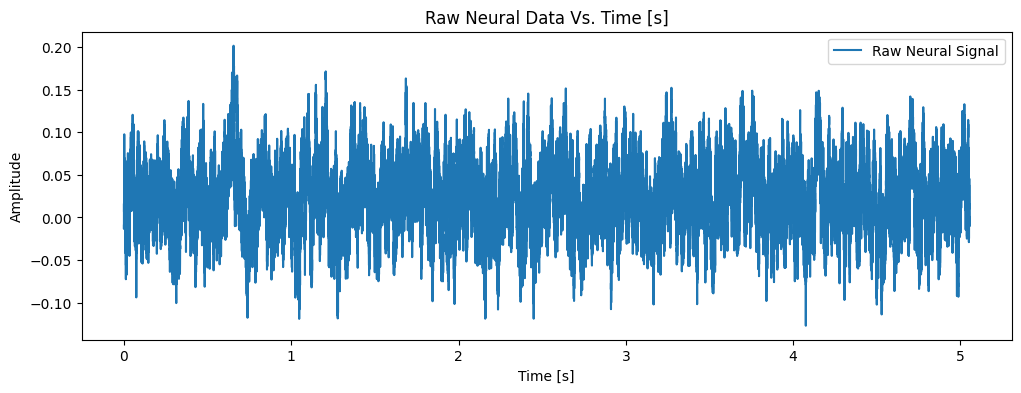

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(time, raw_neural_data)
plt.title('Raw Neural Data Vs. Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(['Raw Neural Signal'])
plt.show()

In [85]:
# It appears there is a trend in the data that is non-zero
detrend_y = scipy.signal.detrend(raw_neural_data)


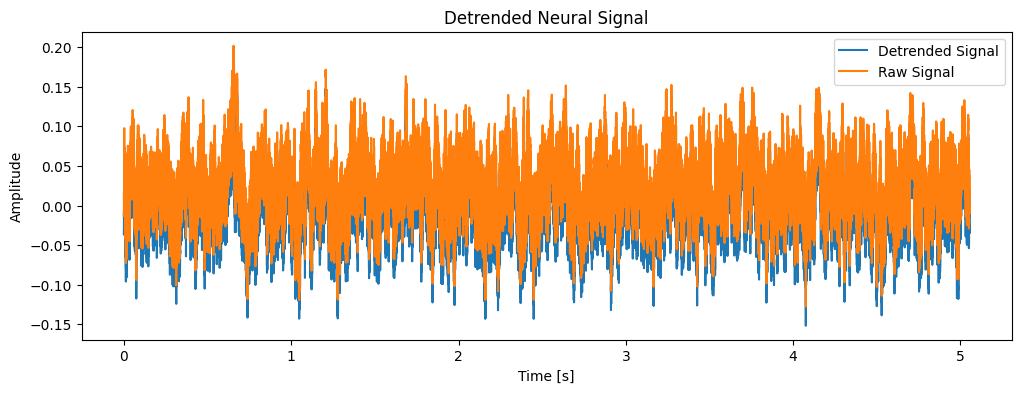

In [86]:
# Plotting the Detrended Signal
plt.figure(figsize=(12, 4))
plt.plot(time, detrend_y, label='Detrended Signal')
plt.plot(time, raw_neural_data, label='Raw Signal')
plt.title('Detrended Neural Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


## Frequency Analysis of Raw Neural Data

In [87]:
FFT = np.fft.fft(detrend_y)
half_length_of_the_FFT = int(len(FFT)/2)

# Creating frequency bins
N = len(FFT)

freq_bins = np.arange(start=0, stop=(sr/2), step=(sr/N))

In [59]:
len(freq_bins) == int(len(FFT)/2)

True

In [60]:
psd = FFT * np.conj(FFT)/ len(FFT)

In [61]:
psd = psd[0:len(psd)//2]

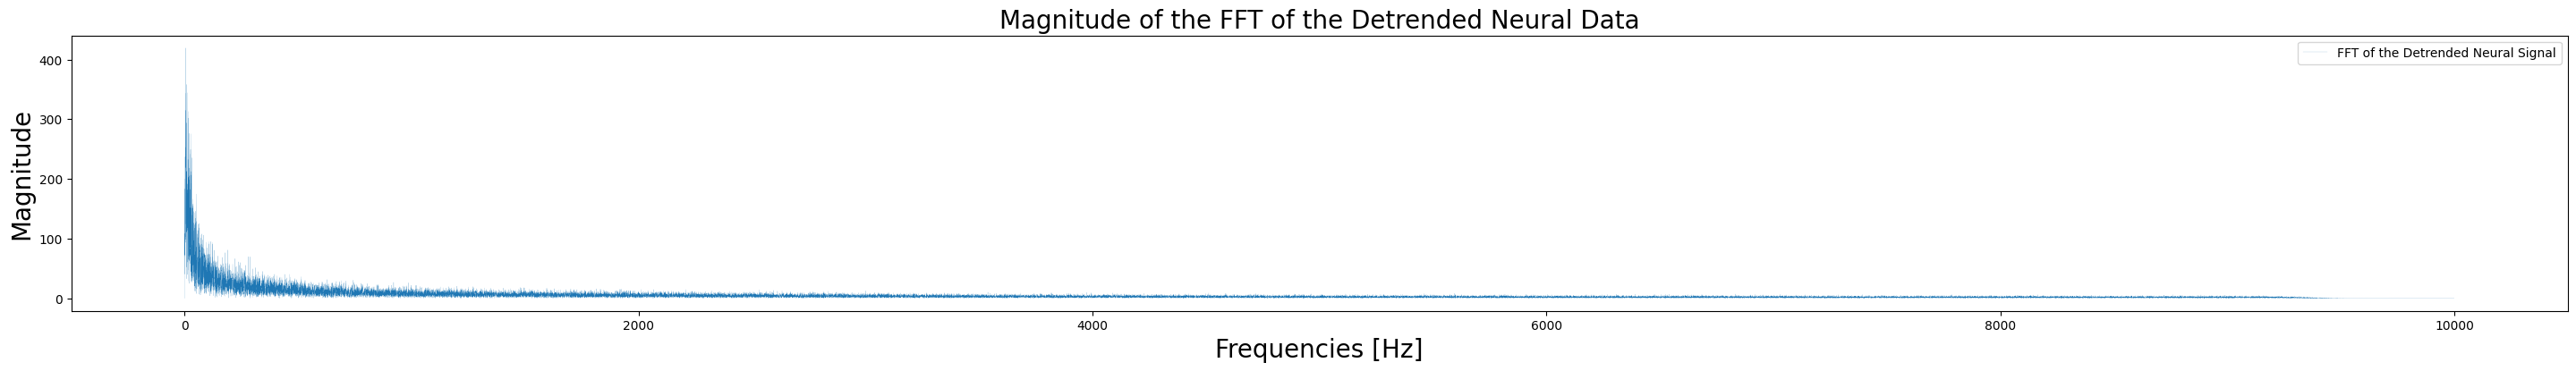

In [62]:
# Plot the Frequency Domain Transform of the Detrended Neural Data
plt.figure(figsize=(36,4))
plt.plot(freq_bins, abs(FFT[0:len(FFT)//2]), 
         label='FFT of the Detrended Neural Signal', linewidth=.1)
plt.title('Magnitude of the FFT of the Detrended Neural Data', fontsize=20)
plt.xlabel('Frequencies [Hz]', fontsize=20)
plt.ylabel('Magnitude', fontsize=20)
plt.legend()
plt.show()

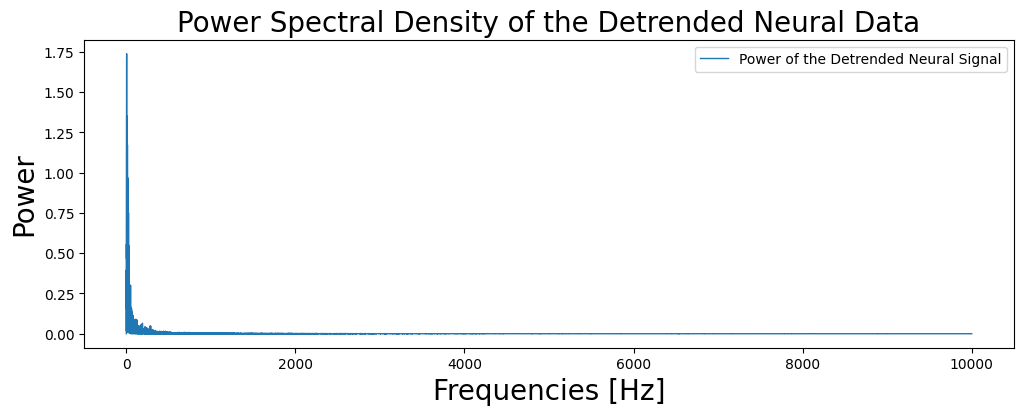

In [63]:
# Plot of the PSD of the Detrended Neural Data
plt.figure(figsize=(12,4))
plt.plot(freq_bins, psd, 
         label='Power of the Detrended Neural Signal', linewidth=1)
plt.title('Power Spectral Density of the Detrended Neural Data', fontsize=20)
plt.xlabel('Frequencies [Hz]', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.legend()
plt.show()


In [64]:
# Sorting the peaks and printing the corresponding indices:
freq_amplitudes = abs(FFT[0:int(len(FFT)/2)])
freq_amplitudes_df = pd.DataFrame(freq_amplitudes, columns = ['Amplitude'])
freq_amplitudes_df_sorted = freq_amplitudes_df.sort_values(by='Amplitude', ascending=False).head(20)

In [65]:
freq_amplitudes_df_sorted.head()

,Amplitude
21,419.206039
22,369.885809
35,358.179650
68,344.337993
27,343.535508


threshold: 0.003318144168252268


/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


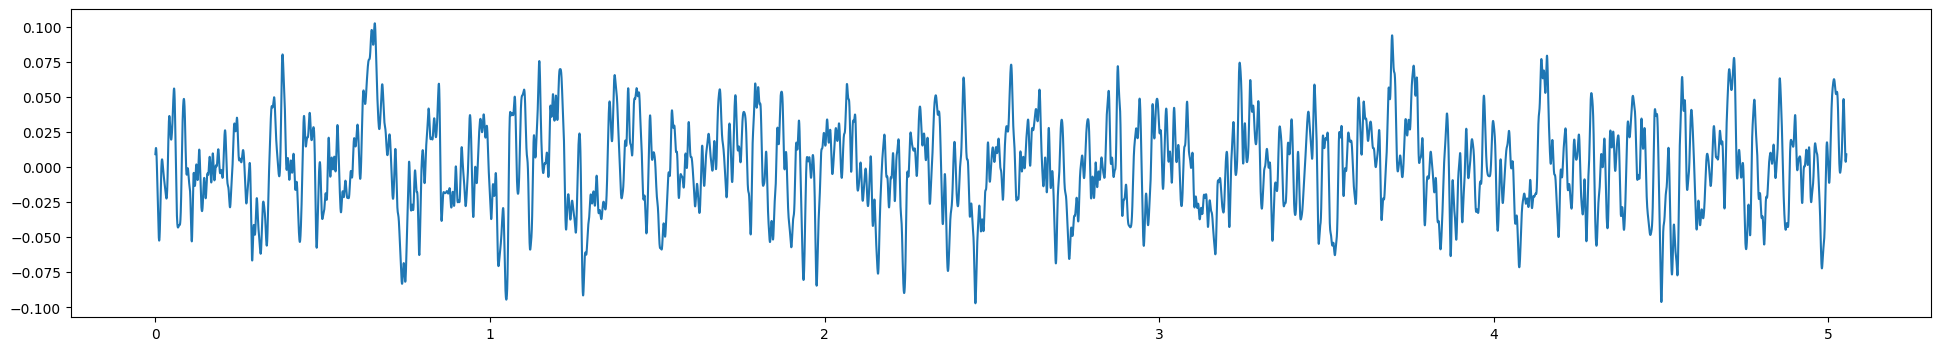

In [88]:

def fft_filter_custom(percentage, freq_bins, FFT):
    threshold = percentage * (2 * abs(FFT[0:len(FFT)//2]) / len(freq_bins)).max()
    print(f"threshold: {threshold}")
    filtered_FFT = FFT.copy()
    filtered_FFT_mag = np.abs(filtered_FFT)
    filtered_FFT_mag = 2*filtered_FFT_mag / len(freq_bins)
    filtered_FFT[filtered_FFT_mag <= threshold]=0
    return filtered_FFT

# Plotting the thresholded FFT
# This is incorrect: the signal is mirrored about the vertical axis of the graph
percentage = 0.2

fft_filtered_custom = fft_filter_custom(percentage, freq_bins, FFT)
time_filtered_custom = np.fft.ifft(fft_filtered_custom)

plt.figure(figsize=(24, 4))
plt.plot(time, time_filtered_custom)
plt.show()


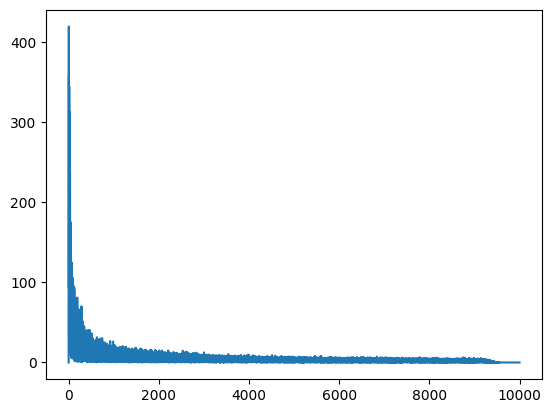

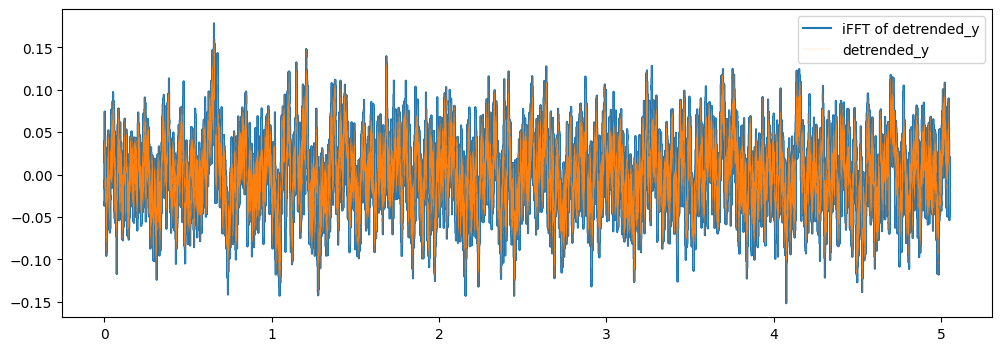

In [67]:

plt.plot(freq_bins, abs(FFT[0:len(FFT)//2]))

iFFT = np.fft.ifft(FFT)
plt.figure(figsize=(12,4))
plt.plot(time, iFFT, label = 'iFFT of detrended_y')
plt.plot(time, detrend_y, linewidth=0.1, label = 'detrended_y')
plt.legend()
plt.show()

In [104]:
type(freq_bins)

numpy.ndarray

threshold: 0.012443040630946003


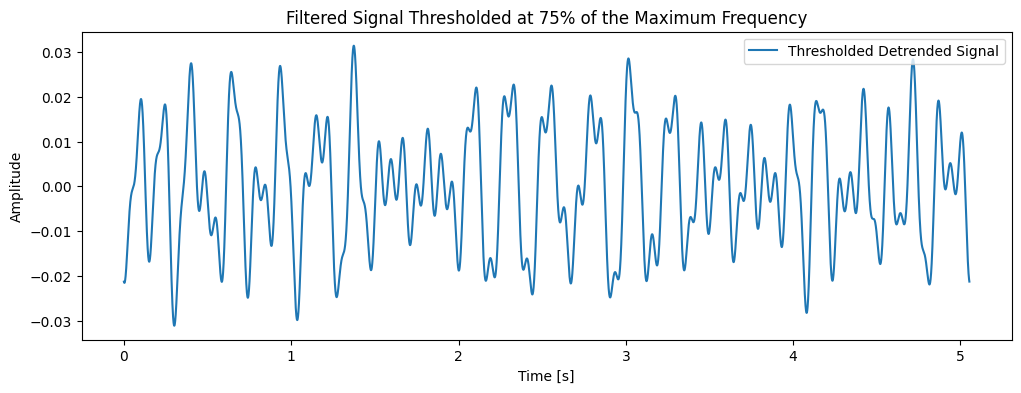

In [68]:
percentage = .75
plt.figure(figsize=(12, 4))
# plt.plot(time, detrend_y, label='Raw Neural Signal', color=list(mcolors.TABLEAU_COLORS.keys())[1])
plt.plot(time, 
         np.fft.ifft(fft_filter_custom(percentage, freq_bins, FFT)), 
         color=list(mcolors.TABLEAU_COLORS.keys())[0],
         label='Thresholded Detrended Signal')  
plt.title('Filtered Signal Thresholded at %0.0f%% of the Maximum Frequency'% (percentage*100))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

##### [Detecting noise by examining the correllation between the residual and the original waveform.](https://towardsdatascience.com/noise-cancellation-with-python-and-fourier-transform-97303314aa71)

## Reading the audio bytes using scipy.io.wavfile

In [69]:
sample_rate, raw_audio_bytes = scipy.io.wavfile.read(data_file_list[0])

In [76]:
print(len(raw_neural_data))
print(len(raw_audio_bytes))

101070
98699


In [71]:
time_end = len(raw_audio_bytes) / sample_rate 
time_end

5.0534534842045975

In [72]:
time = np.arange(start=0, stop=time_end, step=(1/sample_rate))

98699

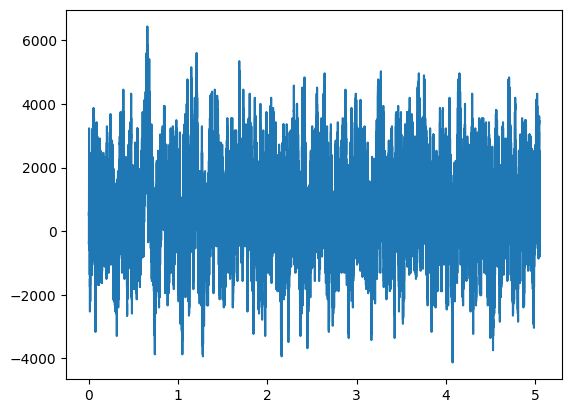

In [73]:
plt.plot(time, raw_audio_bytes)
len(time)


threshold: 0.003318144168252268


/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


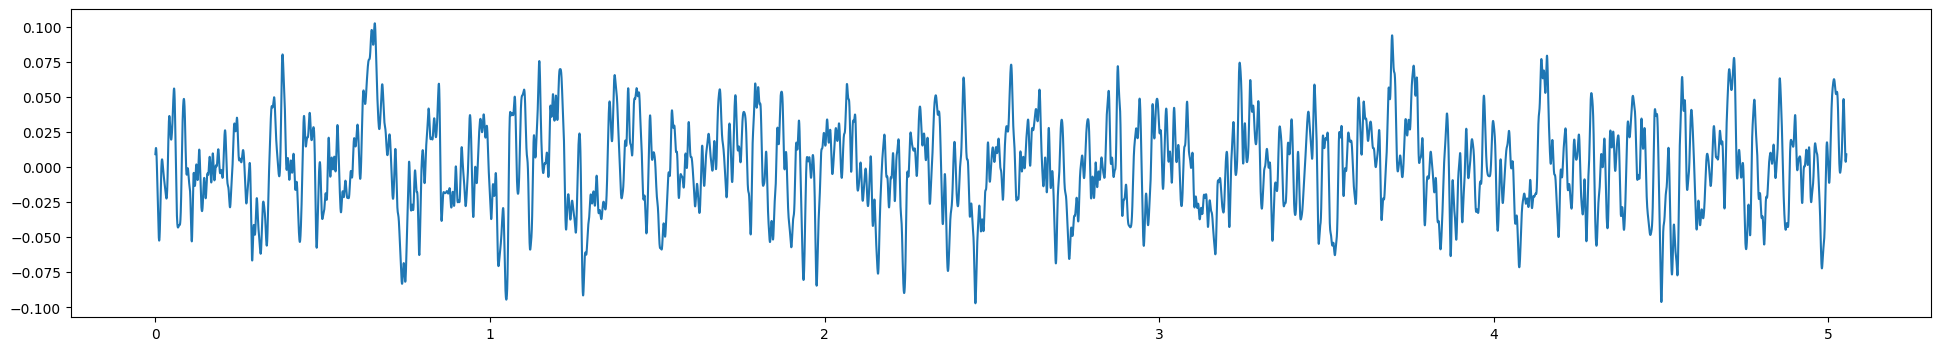

In [103]:
SAMPLE_RATE = 20000
raw_neural_data, sr = librosa.load(data_file_list[0], sr = SAMPLE_RATE)

# It appears there is a trend in the data that is non-zero
detrend_y = scipy.signal.detrend(raw_neural_data)

# FFT = np.fft.fft(detrend_y)
FFT = np.fft.fft(detrend_y)
half_length_of_the_FFT = int(len(FFT)/2)

# Creating frequency bins
N = len(FFT)

freq_bins = np.arange(start=0, stop=(sr/2), step=(sr/N))

def fft_filter_custom(percentage, freq_bins, FFT):
    threshold = percentage * (2 * abs(FFT[0:len(FFT)//2]) / len(freq_bins)).max()
    print(f"threshold: {threshold}")
    filtered_FFT = FFT.copy()
    filtered_FFT_mag = np.abs(filtered_FFT)
    filtered_FFT_mag = 2*filtered_FFT_mag / len(freq_bins)
    filtered_FFT[filtered_FFT_mag <= threshold]=0
    return filtered_FFT

# Plotting the thresholded FFT
# This is incorrect: the signal is mirrored about the vertical axis of the graph
percentage = 0.2

fft_filtered_custom = fft_filter_custom(percentage, freq_bins, FFT)
time_filtered_custom = np.fft.ifft(fft_filtered_custom)

plt.figure(figsize=(24, 4))
plt.plot(time, time_filtered_custom)
plt.show()


In [93]:
time_filtered_custom_bytes = time_filtered_custom.tobytes()